# [RSNA 2023 Abdominal Trauma Detection](https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection)

> Detect and classify traumatic abdominal injuries

![](https://www.kaggle.com/competitions/52254/images/header)

# Idea:
* Same as [RSNA-ATD: CNN [TPU][Train]](https://www.kaggle.com/awsaf49/rsna-atd-cnn-tpu-train/) but with **2.5D** data.
* 2.5D method is simpling stacking different scan of same series to created a `RGB` like image but here each channel is associated with different scans.

# Notebooks
* 2.5D:
    * Train: [RSNA-ATD: 2.5D Series Image [Train]](https://www.kaggle.com/awsaf49/rsna-atd-2-5d-series-image-train)
    * Infer: [RSNA-ATD: 2.5D Series Image [Infer]](https://www.kaggle.com/awsaf49/rsna-atd-2-5d-series-image-infer)
* 2D:
    * Train: [RSNA-ATD: CNN [TPU][Train]](https://www.kaggle.com/awsaf49/rsna-atd-cnn-tpu-train/)
    * Infer: [RSNA-ATD: CNN [TPU][Infer]](https://www.kaggle.com/awsaf49/rsna-atd-cnn-tpu-infer/)

# Install Libraries

In [1]:
!pip install -q keras-cv-attention-models
!pip install -qU wandb
!pip install -qU scikit-learn
!pip install -q seaborn

# Import Libraries

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # to avoid too many logging messages
import pandas as pd, numpy as np, random, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import wandb
import yaml

from IPython import display as ipd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Version Check

In [3]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('tf:',tf.__version__)
print('tfp:', tfp.__version__)
print('tfa:', tfa.__version__)
print('w&b:', wandb.__version__)

np: 1.23.5
pd: 2.0.3
sklearn: 1.3.0
tf: 2.12.0
tfp: 0.20.1
tfa: 0.21.0
w&b: 0.15.10


# Wandb

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management

Some of the cool features of **W&B**:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.

> **Note:** `kaggle_secrets` has not been added to `TPU-VM` yet, so run anonymously then go to the dashbaord and simply `claim` the run.

In [4]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")

    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Configuration

In [5]:
class CFG:
    wandb         = True
    competition   = 'rsna-atd' 
    _wandb_kernel = 'awsaf49'
    debug         = False
    comment       = 'EfficientNetV1B1-512x512-lr2-vflip'
    exp_name      = 'baseline-v5: ds-v3 + multi_head' # name of the experiment, folds will be grouped using 'exp_name'
    
    # use verbose=0 for silent, vebose=1 for interactive,
    verbose      = 0
    display_plot = True

    # device
    device = "TPU-VM" #or "GPU"

    model_name = 'EfficientNetV1B1'

    # seed for data-split, layer init, augs
    seed = 42

    # number of folds for data-split
    folds = 5
    
    # which folds to train
    selected_folds = [0, 1]

    # size of the image
    img_size = [512, 512]
#     eq_dim = np.prod(img_size)**0.5

    # batch_size and epochs
    batch_size = 8
    epochs = 12

    # loss
    loss      = 'BCE & CCE'  # BCE, Focal
    
    # optimizer
    optimizer = 'Adam'

    # augmentation
    augment   = True

    # scale-shift-rotate-shear
    transform = 0.90  # transform prob
    fill_mode = 'constant'
    rot    = 2.0
    shr    = 2.0
    hzoom  = 50.0
    wzoom  = 50.0
    hshift = 10.0
    wshift = 10.0

    # flip
    hflip = True
    vflip = True

    # clip
    clip = False

    # lr-scheduler
    scheduler   = 'exp' # cosine

    # dropout
    drop_prob   = 0.6
    drop_cnt    = 5
    drop_size   = 0.05
    
    # cut-mix-up
    mixup_prob = 0.0
    mixup_alpha = 0.5
    
    cutmix_prob = 0.0
    cutmix_alpha = 2.5

    # pixel-augment
    pixel_aug = 0.90  # prob of pixel_aug
    sat  = [0.7, 1.3]
    cont = [0.8, 1.2]
    bri  = 0.15
    hue  = 0.05

    # test-time augs
    tta = 1
    
    # target column
    target_col  = [ "bowel_injury", "extravasation_injury", "kidney_healthy", "kidney_low",
                   "kidney_high", "liver_healthy", "liver_low", "liver_high",
                   "spleen_healthy", "spleen_low", "spleen_high"] # not using "bowel_healthy" & "extravasation_healthy"


# Reproducibility

In [6]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


# Device Configs
This notebook is compatible for **remote-tpu**, **local-tpu**, **multi-gpu** and **single-gpu**. Simple change to `device="TPU"` for **remote-tpu** and `device="TPU-VM"` for **local-tpu** and finally, `device="GPU"` for single or multi-gpu.

In [7]:
if "TPU" in CFG.device:
    tpu = 'local' if CFG.device=='TPU-VM' else None
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
    except:
        CFG.device = "GPU"
        
if CFG.device == "GPU"  or CFG.device=="CPU":
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    if ngpu>1:
        print("Using multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    elif ngpu==1:
        print("Using single GPU")
        strategy = tf.distribute.get_strategy()
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        CFG.device = "CPU"

if CFG.device == "GPU":
    print("Num GPUs Available: ", ngpu)
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Using single GPU
Num GPUs Available:  1
REPLICAS: 1


# ROOT PATH

In [8]:
BASE_PATH = f'/kaggle/input/rsna-atd-512x512-png-v3-dataset'

# Meta Data

The `train.csv` file contains the following meta information:

- `patient_id`: A unique ID code for each patient.
- `series_id`: A unique ID code for each scan.
- `instance_number`: The image number within the scan. The lowest instance number for many series is above zero as the original scans were cropped to the abdomen.
- `[bowel/extravasation]_[healthy/injury]`: The two injury types with binary targets.
- `[kidney/liver/spleen]_[healthy/low/high]`: The three injury types with three target levels.
- `any_injury`: Whether the patient had any injury at all.


In [9]:
# train
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = f'{BASE_PATH}/train_images'\
                    + '/' + df.patient_id.astype(str)\
                    + '/' + df.series_id.astype(str) +'.png'
df = df.drop_duplicates()
print('Train:')
display(df.head(2))

# test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['image_path'] = f'{BASE_PATH}/test_images'\
                    + '/' + test_df.patient_id.astype(str)\
                    + '/' + test_df.series_id.astype(str) +'.png'
test_df = test_df.drop_duplicates()
print('\nTest:')
display(test_df.head(2))

Train:


,patient_id,series_id,aortic_hu,incomplete_organ,dicom_folder,dicom_paths,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,...,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury,image_path
0,10004,21057,146.00,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,['/kaggle/input/rsna-2023-abdominal-trauma-det...,1,0,0,1,...,1,0,1,0,0,0,0,1,1,/kaggle/input/rsna-atd-512x512-png-v3-dataset/...
1,10004,51033,454.75,0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,['/kaggle/input/rsna-2023-abdominal-trauma-det...,1,0,0,1,...,1,0,1,0,0,0,0,1,1,/kaggle/input/rsna-atd-512x512-png-v3-dataset/...



Test:


,patient_id,series_id,aortic_hu,dicom_folder,dicom_paths,image_path
0,48843,62825,238.0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,['/kaggle/input/rsna-2023-abdominal-trauma-det...,/kaggle/input/rsna-atd-512x512-png-v3-dataset/...
1,50046,24574,149.0,/kaggle/input/rsna-2023-abdominal-trauma-detec...,['/kaggle/input/rsna-2023-abdominal-trauma-det...,/kaggle/input/rsna-atd-512x512-png-v3-dataset/...


# Check If Data Exist?

In [10]:
tf.io.gfile.exists(df.image_path.iloc[0]), tf.io.gfile.exists(test_df.image_path.iloc[0])

(True, True)

## Train-Test Ditribution

In [11]:
print('train_files:',df.shape[0])
print('test_files:',test_df.shape[0])

train_files: 4711
test_files: 3


# Data Split
* Data is splited while stratifying, 'laterality', 'view', 'age','cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density','machine_id', 'difficult_negative_case','cancer'.
* To avoid leakage, data is also split keeping images from same patient in either train or valid not in both.
* `StratifiedGroupKFold` does the both job **stratifying** and **group** split.



In [12]:
df['stratify'] = ''
for col in CFG.target_col:
    df['stratify'] += df[col].astype(str)

df = df.reset_index(drop=True)
skf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['stratify'], df["patient_id"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold', 'patient_id']).size())

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:934: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


fold  patient_id
0.0   19            1
      187           1
      273           1
      310           1
      496           1
                   ..
4.0   64982         2
      65149         1
      65289         2
      65415         1
      65495         1
Length: 3147, dtype: int64

# Data Augmentation
Used simple augmentations, some of them may hurt the model.
* RandomFlip (Left-Right)
* No Rotation
* RandomBrightness
* RndomContrast
* Shear
* Zoom
* Coarsee Dropout/Cutout

In [13]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(
        shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(
        shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

def get_mat(shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    #rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
#     c1   = tf.math.cos(rotation)
#     s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
#     rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
#                                    -s1,  c1,   zero, 
#                                    zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                               zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    

    return  K.dot(shear_matrix,K.dot(zoom_matrix, shift_matrix)) #K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))                  

def transform(image, DIM=CFG.img_size):#[rot,shr,h_zoom,w_zoom,h_shift,w_shift]):
    if DIM[0]>DIM[1]:
        diff  = (DIM[0]-DIM[1])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]],[0, 0]])
        NEW_DIM = DIM[0]
    elif DIM[0]<DIM[1]:
        diff  = (DIM[1]-DIM[0])
        pad   = [diff//2, diff//2 + diff%2]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0],[0, 0]])
        NEW_DIM = DIM[1]
    
    rot = CFG.rot * tf.random.normal([1], dtype='float32')
    shr = CFG.shr * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    h_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    w_shift = CFG.wshift * tf.random.normal([1], dtype='float32') 
    
    transformation_matrix=tf.linalg.inv(get_mat(shr,h_zoom,w_zoom,h_shift,w_shift))
    
    flat_tensor=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)
    
    image=tfa.image.transform(image,flat_tensor, fill_mode=CFG.fill_mode)
    
    rotation = math.pi * rot / 180.
    
    image=tfa.image.rotate(image,-rotation, fill_mode=CFG.fill_mode)
    
    if DIM[0]>DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,4])
        image = image[:, pad[0]:-pad[1],:]
    elif DIM[1]>DIM[0]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,4])
        image = image[pad[0]:-pad[1],:,:]
    image = tf.reshape(image, [*DIM, 4])    
    return image

def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, CT = 5, SZ = 0.1):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): 
        return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM[0],y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM[1],x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,4], dtype = image.dtype) 
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,4])

#     image = tf.reshape(image,[*DIM,3])
    return image


def ColorAug(img, prob):
    if random_float() > prob:
        return img
    # Get the shape of the input image
    shape = tf.shape(img)
    # Separate the alpha channel from the image
    img_rgb, img_alpha = img[..., :3], img[..., 3:]
    # Apply random adjustments to the RGB channels
    img_rgb = tf.image.random_hue(img_rgb, CFG.hue)
    img_rgb = tf.image.random_saturation(img_rgb, CFG.sat[0], CFG.sat[1])
    img_rgb = tf.image.random_contrast(img_rgb, CFG.cont[0], CFG.cont[1])
    img_rgb = tf.image.random_brightness(img_rgb, CFG.bri)
    # Combine the adjusted RGB channels with the original alpha channel
    img = tf.concat([img_rgb, img_alpha], axis=-1)
    # Reshape the image to the original input shape
    img = tf.reshape(img, shape)
    return img

## Data Pipeline
* Reads the raw file and then decodes it to tf.Tensor
* Resizes the image in desired size
* Chages the datatype to **float32**
* Caches the Data for boosting up the speed.
* Uses Augmentations to reduce overfitting and make model more robust.
* Finally, splits the data into batches.


In [14]:
def build_decoder(with_labels=True, target_size=CFG.img_size, ext='png'):
    def decode_image(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=4, dtype=tf.uint8)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size, method='bilinear')
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*target_size, 4])

        return img
    
    def decode_label(label):
        label = tf.cast(label, tf.float32)
        return (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])
    
    def decode_with_labels(path, label):
        return decode_image(path), decode_label(label)
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True, dim=CFG.img_size):
    def augment(img, dim=dim):
        if random_float() < CFG.transform:
            img = transform(img,DIM=dim)
        img = tf.image.random_flip_left_right(img) if CFG.hflip else img
        img = tf.image.random_flip_up_down(img) if CFG.vflip else img
        img = ColorAug(img, prob=CFG.pixel_aug)
        img = tf.clip_by_value(img, 0, 1)  if CFG.clip else img         
        img = tf.reshape(img, [*dim, 4])
        return img
    
    def augment_with_labels(img, label):    
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    if augment and labels is not None:
        ds = ds.map(lambda img, label: (dropout(img, 
                                               DIM=CFG.img_size, 
                                               PROBABILITY=CFG.drop_prob, 
                                               CT=CFG.drop_cnt,
                                               SZ=CFG.drop_size), label),num_parallel_calls=AUTO)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

## Visualization
* Check if augmentation is working properly or not.

In [15]:
def display_batch(batch, size=2):
    if isinstance(batch, tuple):
        imgs, tars = batch
    else:
        imgs = batch
        tars = None
    tars = tf.concat(tars,axis=-1).numpy()
    plt.figure(figsize=(size*5, 10))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        if tars is not None:
            plt.title(f'{tars[img_idx].round(2)}', fontsize=12)
        img = imgs[img_idx,]
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show() 

## Generate Image

In [16]:
fold = 0
fold_df = df[df.fold==fold].sample(frac=1.0)
paths  = fold_df.image_path.tolist()
labels = fold_df[CFG.target_col].values
ds = build_dataset(paths, labels, cache=False, batch_size=32,
                   repeat=True, shuffle=True, augment=False)
ds = ds.unbatch().batch(20)
batch = next(iter(ds))

## No-Augmentation

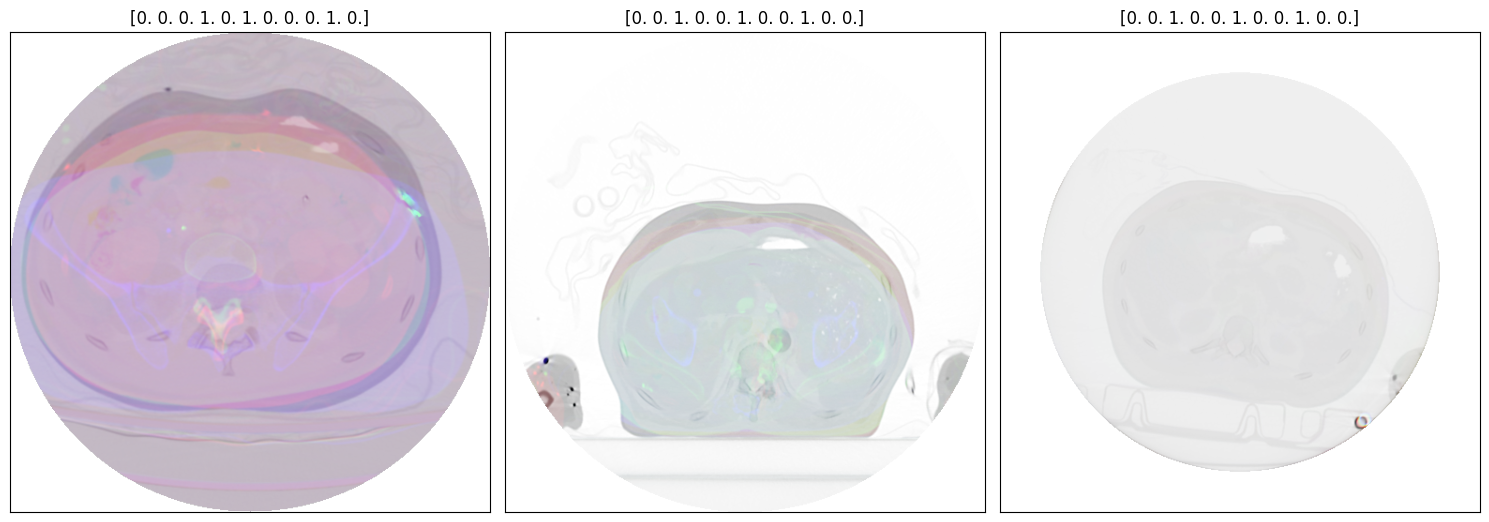

In [17]:
display_batch(batch, 3);

## Dropout

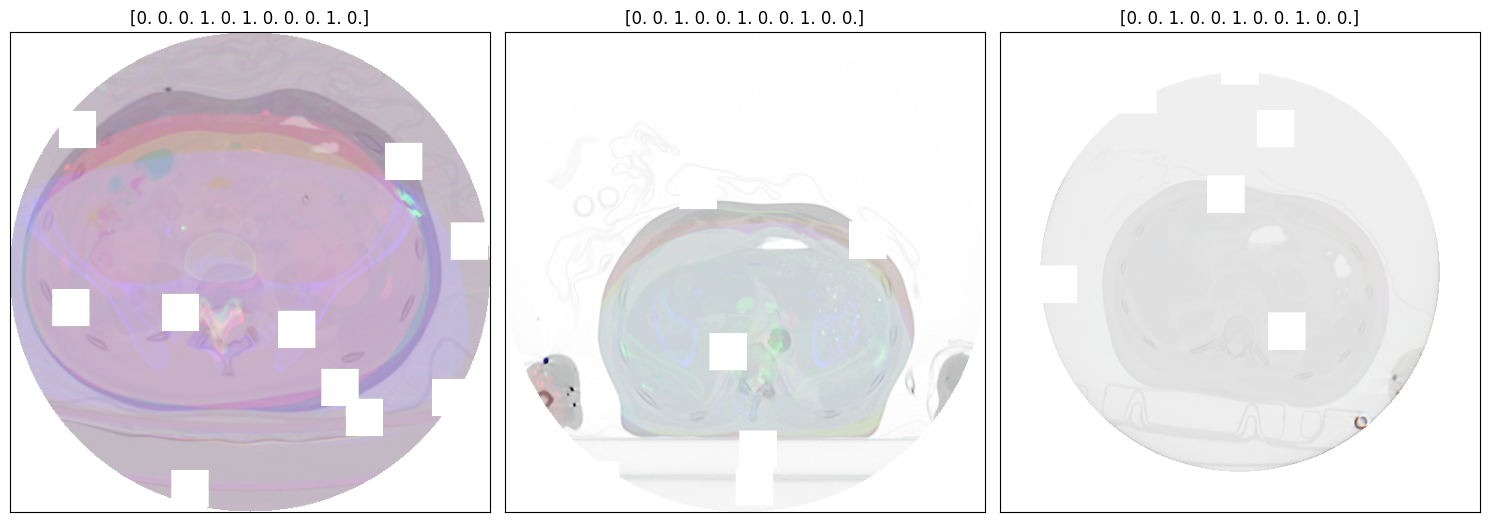

In [18]:
dimgs = tf.map_fn(lambda img: dropout(img,
                DIM=CFG.img_size, 
                PROBABILITY=1.0, 
                CT=10,
                SZ=0.08), batch[0])
dtars = batch[1]
display_batch((dimgs, dtars), 3);

## Affine Transform

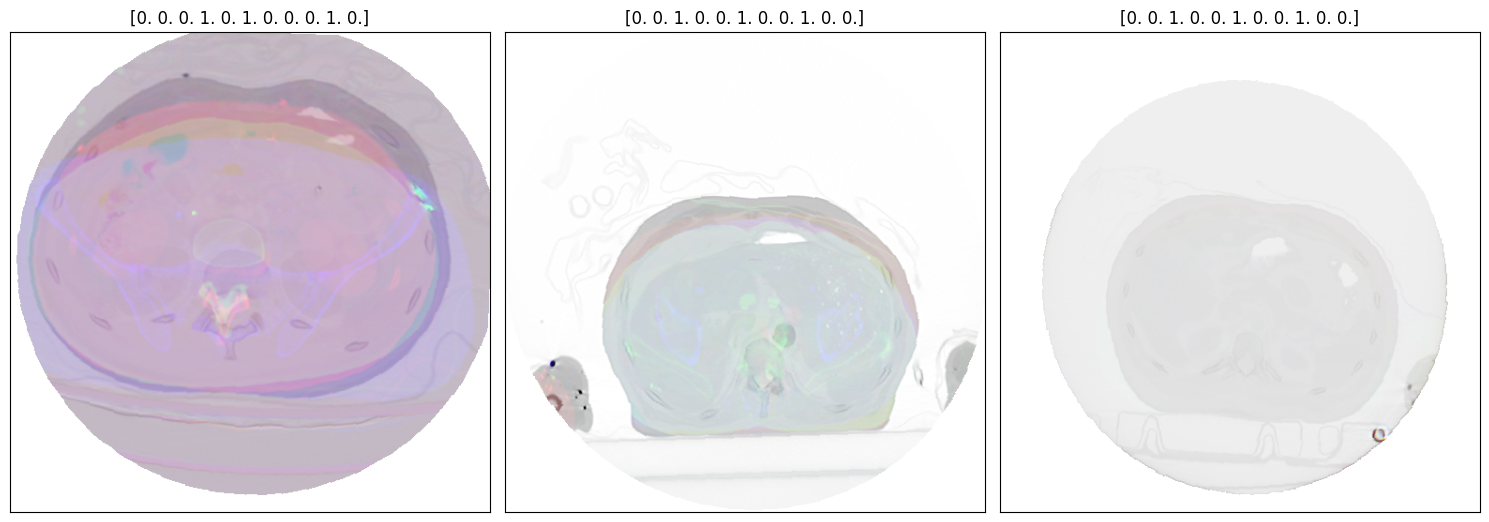

In [19]:
timgs = tf.map_fn(lambda img: transform(img,DIM=CFG.img_size), batch[0])
ttars = batch[1]
display_batch((timgs, ttars), 3);

# Loss Function
We'll use Binary Cross Entropy loss for `bowel` and `extravasation` at the same time we'll use Categorical Cross Entropy for `kidney`, `liver` and `spleen`.
<!-- ## BCE
Loss Function for this notebook is **BCE: Binary Crossentropy** or **Focal** as the task is **binary classification**

$$\textrm{BCE}  = -\frac{1}{N} \sum_{i=1}^{N} y_i \cdot log(\hat{y}_i) + (1 - y_i) \cdot log(1 - \hat{y}_i)$$

where $\hat{y}_i$ is the **predicted** value and $y_i$ is the **original** value for each instance $i$.

## Focal
$$\textrm{FL} = -\alpha_{t}(1 - p_{t})^{\gamma}\log{p_{t}}$$

$\gamma$ controls the shape of the curve. The higher the value of $\gamma$, the lower the loss for well-classified examples, so we could turn the attention of the model more towards ‘hard-to-classify examples. FL gives high weights to the rare class and small weights to the dominating or common class. These weights are referred to as $\alpha$.


## Code
* `tf.keras.losses.BinaryCrossentropy`
* `tfa.losses.SigmoidFocalCrossEntropy` -->

# Build Model

In [20]:
from keras_cv_attention_models import efficientnet

def channel_squeezer(x):
    # Expand 4 channels to 32 features
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='gelu')(x)
    # Squeeze 32 features into 3 channels
    x = tf.keras.layers.Conv2D(3, (3, 3), padding='same', activation='gelu')(x)
    return x

def build_model(model_name=CFG.model_name,
                loss_name=CFG.loss,
                dim=CFG.img_size,
                compile_model=True,
                include_top=False):         

    # Input layer for 4-channel images
    inp = tf.keras.layers.Input(shape=(*dim, 4))
    # Squeeze 4 channels to 3 channels
    x = channel_squeezer(inp)
    # Define backbone
    base = getattr(efficientnet, model_name)(input_shape=(*dim,3),
                                    pretrained='imagenet',
                                    num_classes=0) # get base model (efficientnet), use imgnet weights
    x = base(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # use GAP to get pooling result form conv outputs

    # Define 'necks' for each head
    x_bowel = tf.keras.layers.Dense(32, activation='silu')(x)
    x_extra = tf.keras.layers.Dense(32, activation='silu')(x)
    x_liver = tf.keras.layers.Dense(32, activation='silu')(x)
    x_kidney = tf.keras.layers.Dense(32, activation='silu')(x)
    x_spleen = tf.keras.layers.Dense(32, activation='silu')(x)

    # Define heads
    out_bowel = tf.keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = tf.keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = tf.keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = tf.keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = tf.keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head

    # Combine outputs
#     out = tf.keras.layers.Concatenate()([out_bowel, out_extra, 
#                                          out_liver, out_kidney, out_spleen])
    out = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    model = tf.keras.Model(inputs=inp, outputs=out)

    
    if compile_model:
        # optimizer
        opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
        # loss
        loss = {
            'bowel':tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
            'extra':tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
            'liver':tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
            'kidney':tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
            'spleen':tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        }
        # metric
        metrics = {
            'bowel':['accuracy'],
            'extra':['accuracy'],
            'liver':['accuracy'],
            'kidney':['accuracy'],
            'spleen':['accuracy'],
        }
        # compile
        model.compile(optimizer=opt,
                      loss=loss,
                      metrics=metrics)
    return model

## Model Check

In [21]:
tmp = build_model(CFG.model_name, dim=CFG.img_size, compile_model=True)
tmp.summary()  # too long

32381008/32381008 [==============================] - 0s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv1-b1-imagenet.h5
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  1184        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 3)

# Learning-Rate Scheduler

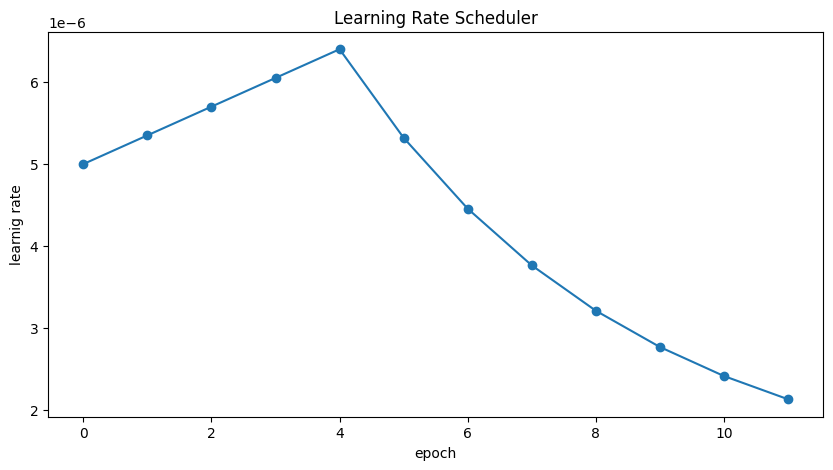

In [22]:
def get_lr_callback(batch_size=8, plot=False):
    lr_start   = 0.000005
    lr_max     = 0.00000080 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        elif CFG.scheduler=='exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        elif CFG.scheduler=='cosine':
            decay_total_epochs = CFG.epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.4 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lrfn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

_=get_lr_callback(CFG.batch_size, plot=True )

# **Wandb** Logger
Log:
* Best Score
* Attention MAP

In [23]:
# create directory to save gradcam imgs
!mkdir -p gradcam

# intialize wandb run
def wandb_init(fold):
    config = {k:v for k,v in dict(vars(CFG)).items() if '__' not in k}
    config.update({"fold":int(fold)})
    yaml.dump(config, open(f'/kaggle/working/config fold-{fold}.yaml', 'w'),)
    config = yaml.load(open(f'/kaggle/working/config fold-{fold}.yaml', 'r'), Loader=yaml.FullLoader)
    run    = wandb.init(project="rsna-atd-public",
               name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
               config=config,
               anonymous=anonymous,
               group=CFG.comment
                    )
    return run

def log_wandb(fold):
    "log best result for error analysis"
    # log values to wandb
    wandb.log({
               'best_acc': best_acc,
               'best_loss': best_loss,
               'best_epoch': best_epoch+1,
               'best_acc_bowel': best_acc_bowel,
               'best_acc_extra': best_acc_extra,
               'best_acc_liver': best_acc_liver,
               'best_acc_kidney': best_acc_kidney,
               'best_acc_spleen': best_acc_spleen,
              })


## `WandbModelCheckpoint` and `WandbMetricsLogger`
Newly released callbacks offers more flexibility in terms of customization and also they are compact comparing classic `WandbCallback` hence it easier to use. Here's a brief intro about them,

* **WandbModelCheckpoint**: This callback saves model or weights using `tf.keras.callbacks.ModelCheckpoint`, hence we can harness the power of official tf callback to do so much more such log `tf.keras.Model` subclass model in TPU. 

* **WandbMetricsLogger**: This callback simply logs all the metrics and losses.

* **WandbEvalCallback**: This one is even more special, we can use it to log model's prediction after certain epoch/frequency. We can use it to save segmentation mask, bounding boxes and gradcam within epochs to check intermediate result.

For more details, check [here](https://docs.wandb.ai/ref/python/integrations/keras)

In [24]:
# get wandb callbacks
def get_wb_callbacks(fold):
    wb_ckpt = wandb.keras.WandbModelCheckpoint(filepath='fold-%i.h5'%fold, 
                                               monitor='val_loss',
                                               verbose=CFG.verbose,
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='min',)
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_ckpt, wb_metr]

# Train Model
* Cross-Validation: 5 fold
* **WandB** dashboard is shown end of the each fold. So we don't need to plot anything. We can select best model from here.

In [25]:
scores = []

for fold in np.arange(CFG.folds):
    
    # ignore not selected folds
    if fold not in CFG.selected_folds:
        continue
        
    # init wandb
    if CFG.wandb:
        run = wandb_init(fold)
        wb_callbacks = get_wb_callbacks(fold)
            
    # train and valid dataframe
    train_df = df[df.fold != fold]
    valid_df = df[df.fold == fold]
    
    # get image_paths and labels
    train_paths = train_df.image_path.values; train_labels = train_df[CFG.target_col].values.astype(np.float32)
    valid_paths = valid_df.image_path.values; valid_labels = valid_df[CFG.target_col].values.astype(np.float32)
    test_paths  = test_df.image_path.values
    
    # shuffle train data
    index = np.arange(len(train_df))
    np.random.shuffle(index)
    train_paths  = train_paths[index]
    train_labels = train_labels[index]
    
    # min samples in debug mode
    min_samples = CFG.batch_size*REPLICAS*2
    
    # for debug model run on small portion
    if CFG.debug:
        train_paths = train_paths[:min_samples]; train_labels = train_labels[:min_samples]
        valid_paths = valid_paths[:min_samples]; valid_labels = valid_labels[:min_samples]
    
    # show message
    print('#'*40); print('#### FOLD: ',fold)
    print('#### IMAGE_SIZE: (%i, %i) | MODEL_NAME: %s | BATCH_SIZE: %i'%
          (CFG.img_size[0],CFG.img_size[1],CFG.model_name,CFG.batch_size*REPLICAS))
    
    # data stat
    num_train = len(train_paths)
    num_valid = len(valid_paths)
    if CFG.wandb:
        wandb.log({'num_train':num_train,
                   'num_valid':num_valid})
    print('#### NUM_TRAIN: {:,} | NUM_VALID: {:,}'.format(num_train, num_valid))
    
    # build model
    K.clear_session()
    with strategy.scope():
        model = build_model(CFG.model_name, dim=CFG.img_size, compile_model=True)

    # build dataset
    cache = 1 if 'TPU' in CFG.device else 0
    train_ds = build_dataset(train_paths, train_labels, cache=cache, batch_size=CFG.batch_size*REPLICAS,
                   repeat=True, shuffle=True, augment=CFG.augment)
    val_ds = build_dataset(valid_paths, valid_labels, cache=cache, batch_size=CFG.batch_size*REPLICAS,
                   repeat=False, shuffle=False, augment=False)
    print('#'*40)   
    
    # callbacks
    callbacks = []
    ## save best model after each fold
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_loss', verbose=CFG.verbose, save_best_only=True,
        save_weights_only=False, mode='min', save_freq='epoch')
    callbacks +=[sv]
    ## lr-scheduler
    callbacks += [get_lr_callback(CFG.batch_size)]
    ## wandb callbacks
    if CFG.wandb:
        callbacks += wb_callbacks
        
    # train
    print('Training...')
    history = model.fit(
        train_ds, 
        epochs=CFG.epochs if not CFG.debug else 2, 
        callbacks = callbacks, 
        steps_per_epoch=len(train_paths)/CFG.batch_size//REPLICAS,
        validation_data=val_ds, 
        verbose=CFG.verbose
    )
    
    # store best results
    best_epoch = np.argmin(history.history['val_loss'])
    best_loss = history.history['val_loss'][best_epoch]
    best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
    best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
    best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
    best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
    best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

    # Find mean accuracy
    best_acc = np.mean([best_acc_bowel, best_acc_extra, 
                        best_acc_liver, best_acc_kidney, best_acc_spleen])

    print(f'\n{"="*17} FOLD {fold} RESULTS {"="*17}')
    print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch + 1}\n')
    print('ORGAN Acc:')
    print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
    print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
    print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
    print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
    print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

    print(f'{"="*50}\n')

    scores.append([best_loss, best_acc, 
                   best_acc_bowel, best_acc_extra, 
                   best_acc_liver, best_acc_kidney, best_acc_spleen])
    
    # log best result on wandb & plot
    if CFG.wandb:
        log_wandb(fold) # log
        wandb.run.finish() # finish the run
        display(ipd.IFrame(run.url, width=1080, height=720)) # show wandb dashboard

wandb: Currently logged in as: awsaf49. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230915_161936-zkr2q4j9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fold-0|dim-512x512|model-EfficientNetV1B1
wandb: ⭐️ View project at https://wandb.ai/awsaf49/rsna-atd-public
wandb: 🚀 View run at https://wandb.ai/awsaf49/rsna-atd-public/runs/zkr2q4j9
wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


########################################
#### FOLD:  0
#### IMAGE_SIZE: (512, 512) | MODEL_NAME: EfficientNetV1B1 | BATCH_SIZE: 8
#### NUM_TRAIN: 3,779 | NUM_VALID: 932
>>>> Load pretrained from: /root/.keras/models/efficientnetv1-b1-imagenet.h5
########################################
Training...


wandb: Waiting for W&B process to finish... (success).



================= FOLD 0 RESULTS =================
>>>> BEST Loss  : 1.749
>>>> BEST Acc   : 0.932
>>>> BEST Epoch : 12

ORGAN Acc:
  >>>> Bowel           : 0.981
  >>>> Extravasation   : 0.946
  >>>> Liver           : 0.933
  >>>> Kidney          : 0.900
  >>>> Spleen          : 0.899



wandb: 
wandb: Run history:
wandb:                  best_acc ▁
wandb:            best_acc_bowel ▁
wandb:            best_acc_extra ▁
wandb:           best_acc_kidney ▁
wandb:            best_acc_liver ▁
wandb:           best_acc_spleen ▁
wandb:                best_epoch ▁
wandb:                 best_loss ▁
wandb:      epoch/bowel_accuracy ▁███████████
wandb:          epoch/bowel_loss █▂▁▁▁▁▁▁▁▁▁▁
wandb:               epoch/epoch ▁▂▂▃▄▄▅▅▆▇▇█
wandb:      epoch/extra_accuracy ▁███████████
wandb:          epoch/extra_loss █▂▁▁▁▁▁▁▁▁▁▁
wandb:     epoch/kidney_accuracy ▁███████████
wandb:         epoch/kidney_loss █▂▁▁▁▁▁▁▁▁▁▁
wandb:       epoch/learning_rate ▆▆▇▇█▆▅▄▃▂▁▁
wandb:      epoch/liver_accuracy ▁███████████
wandb:          epoch/liver_loss █▂▁▁▁▁▁▁▁▁▁▁
wandb:                epoch/loss █▂▁▁▁▁▁▁▁▁▁▁
wandb:                  epoch/lr ▆▆▇▇█▆▅▄▃▂▁▁
wandb:     epoch/spleen_accuracy ▁███████████
wandb:         epoch/spleen_loss █▂▂▁▁▁▁▁▁▁▁▁
wandb:  epoch/val_bowel_accuracy ▁▁██▁███████
wa

wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230915_171317-ywfqmpaa
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fold-1|dim-512x512|model-EfficientNetV1B1
wandb: ⭐️ View project at https://wandb.ai/awsaf49/rsna-atd-public
wandb: 🚀 View run at https://wandb.ai/awsaf49/rsna-atd-public/runs/ywfqmpaa


########################################
#### FOLD:  1
#### IMAGE_SIZE: (512, 512) | MODEL_NAME: EfficientNetV1B1 | BATCH_SIZE: 8
#### NUM_TRAIN: 3,768 | NUM_VALID: 943
>>>> Load pretrained from: /root/.keras/models/efficientnetv1-b1-imagenet.h5
########################################
Training...


wandb: Waiting for W&B process to finish... (success).



================= FOLD 1 RESULTS =================
>>>> BEST Loss  : 1.802
>>>> BEST Acc   : 0.930
>>>> BEST Epoch : 9

ORGAN Acc:
  >>>> Bowel           : 0.975
  >>>> Extravasation   : 0.947
  >>>> Liver           : 0.953
  >>>> Kidney          : 0.893
  >>>> Spleen          : 0.882



wandb: 
wandb: Run history:
wandb:                  best_acc ▁
wandb:            best_acc_bowel ▁
wandb:            best_acc_extra ▁
wandb:           best_acc_kidney ▁
wandb:            best_acc_liver ▁
wandb:           best_acc_spleen ▁
wandb:                best_epoch ▁
wandb:                 best_loss ▁
wandb:      epoch/bowel_accuracy ▁███████████
wandb:          epoch/bowel_loss █▂▁▁▁▁▁▁▁▁▁▁
wandb:               epoch/epoch ▁▂▂▃▄▄▅▅▆▇▇█
wandb:      epoch/extra_accuracy ▁███████████
wandb:          epoch/extra_loss █▂▁▁▁▁▁▁▁▁▁▁
wandb:     epoch/kidney_accuracy ▁███████████
wandb:         epoch/kidney_loss █▂▂▁▁▁▁▁▁▁▁▁
wandb:       epoch/learning_rate ▆▆▇▇█▆▅▄▃▂▁▁
wandb:      epoch/liver_accuracy ▁███████████
wandb:          epoch/liver_loss █▂▁▁▁▁▁▁▁▁▁▁
wandb:                epoch/loss █▂▁▁▁▁▁▁▁▁▁▁
wandb:                  epoch/lr ▆▆▇▇█▆▅▄▃▂▁▁
wandb:     epoch/spleen_accuracy ▁███████████
wandb:         epoch/spleen_loss █▂▁▁▁▁▁▁▁▁▁▁
wandb:  epoch/val_bowel_accuracy ▁███████████
wa

# Calculate OOF Score

In [26]:
# overall oof pF1
oof_loss, oof_acc, oof_acc_bowel, oof_acc_extra, oof_acc_liver, oof_acc_kidney, oof_acc_spleen = np.array(scores).mean(axis=0)

print(f'\n{"="*15} OVERALL OOF RESULTS {"="*15}')
print(f'>>>> OOF BEST Loss : {oof_loss:.3f}\n>>>> OOF BEST Acc  : {oof_acc:.3f}\n')
print('ORGAN OOF Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {oof_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {oof_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {oof_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {oof_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {oof_acc_spleen:.3f}')
print(f'{"="*50}\n')



=============== OVERALL OOF RESULTS ===============
>>>> OOF BEST Loss : 1.776
>>>> OOF BEST Acc  : 0.931

ORGAN OOF Acc:
  >>>> Bowel           : 0.978
  >>>> Extravasation   : 0.947
  >>>> Liver           : 0.943
  >>>> Kidney          : 0.897
  >>>> Spleen          : 0.891



# Remove Files

In [27]:
!rm -r /kaggle/working/wandb

# Reference:
1. [RANZCR: EfficientNet TPU Training](https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training)
1. [Triple Stratified KFold with TFRecords](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords)